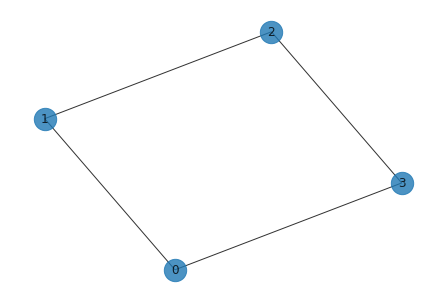

In [1]:
from functools import reduce
import networkx as nx
from networkx import Graph

g = Graph()
g.add_nodes_from([0, 1, 2, 3])
g.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(g, with_labels=True, alpha=0.8, node_size=500)

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit import Aer, execute
from qiskit.circuit import Parameter

In [3]:
def mixer(g: Graph, beta: float):
    qubits = QuantumRegister(g.number_of_nodes())

    qc_mix = QuantumCircuit(qubits)
    for q in qubits:
        qc_mix.rx(2 * beta, q)

    return qc_mix

In [4]:
def problem(g: Graph, gamma: float):
    qc_problem = QuantumCircuit(g.number_of_nodes())
    for i, j in g.edges():  # pairs of nodes
        qc_problem.rzz(2 * gamma, i, j)

    return qc_problem

In [5]:
def maxcut_obj(x: str, g: Graph):
    return reduce(lambda obj, e : obj - (1 if x[e[0]] != x[e[1]] else 0), g.edges(), 0)

In [6]:
def compute_expectation(counts, g: Graph):
    avg, sum_count = reduce(lambda t, c: (t[0] + (maxcut_obj(c[0], g) * c[1]), t[1] + c[1]), counts.items(), (0, 0))
    return avg/sum_count

In [7]:
def create_qaoa_circ(g: Graph, theta: list[float]):
    qubits = QuantumRegister(g.number_of_nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(qubits)

    beta = theta[:p]
    gamma = theta[p:]

    # initial_state
    for q in qubits:
        qc.h(q)

    for irep in range(p):
        qc.append(problem(g, gamma[irep]), qubits)
        qc.append(mixer(g, beta[irep]), qubits)

    qc.measure_all()

    return qc

In [8]:
def get_expectation(g: Graph, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta: list[int]):
        qc = create_qaoa_circ(g, theta)
        counts = backend.run(transpile(qc, backend), nshots=512).result().get_counts()
        return compute_expectation(counts, g)

    return execute_circ

In [19]:
from scipy.optimize import minimize

expectation = get_expectation(g)
res = minimize(expectation, [1.0, 1.0, 1.0, 1.0], method='COBYLA')
res

     fun: -3.935546875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 47
  status: 1
 success: True
       x: array([2.10800237, 2.10754162, 1.02217591, 1.06840903])

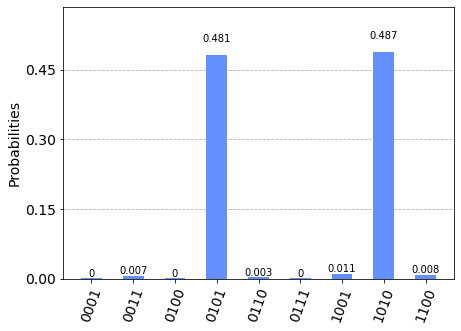

In [20]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(g, res.x)

counts = backend.run(transpile(qc_res, backend)).result().get_counts()

plot_histogram(counts)